In [169]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils.model_operations import *
from utils.image_operations import *

directory_path = os.getcwd()

In [170]:
def loadModelWeights(setName, percentage=1):
    """
    setname: either "train" or "test"
    
    returns dataframe with the weights of all models by layers
    """
    bias = ['0.02', '0.03', '0.04', '0.05']
    df = pd.DataFrame()
    modelId = 0
    for b in bias:
        if setName == "train":
            model_data = ModelDataset(bias=b, data_directory=directory_path+'/data/DigitWdb/train')
        elif setName == "test":
            model_data = ModelDataset(bias=b, data_directory=directory_path+'/data/DigitWdb/test')
        else:
            raise "set name must either be train or test"
            
        for modelNumber in tqdm(range(len(model_data)//percentage), desc="loading model weights with bias "+b):
            model = model_data[modelNumber]
            layerNumber = 0
            for layer in model.layers:
                if len(layer.get_weights()) != 0:
                    # weights
                    weights = layer.get_weights()[0]
                    # biases
                    biases = layer.get_weights()[1]

                    df = df.append({'modelId':modelId,'weights':np.ravel(weights),'biases':np.ravel(biases),'layer':layerNumber, 'bias':b}, ignore_index=True)
                    layerNumber = layerNumber + 1
            modelId += 1       
    return df


In [3]:
trainModelWeights = loadModelWeights("train", percentage = 100)
testModelWeights = loadModelWeights("test",  percentage = 100)

loading model weights with bias 0.02:   0%|          | 0/20 [00:00<?, ?it/s]2021-12-19 12:35:54.194795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
loading model weights with bias 0.05: 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


In [4]:
trainModelWeights

,modelId,weights,biases,layer,bias
0,0.0,"[-0.018486138, -0.03354981, -0.16535422, -0.06...","[-0.24564764, -0.081536554, -0.01958792, -0.11...",0.0,0.02
1,0.0,"[-0.26035, -0.031969644, 0.02034611, 0.0241116...","[-0.08751261, 0.14474091, -0.26124775, -0.2221...",1.0,0.02
2,0.0,"[-0.045246184, -0.022445709, -0.17450637, -0.0...","[0.18726698, -0.055855844, 0.10226409, -0.1979...",2.0,0.02
3,0.0,"[0.14023237, -0.0014608316, 0.17644557, 0.1682...","[-0.11819455, 0.109577455, -0.034734905, 0.126...",3.0,0.02
4,0.0,"[-0.25628987, 0.017059373, -0.14892107, 0.1850...","[0.04371279, 0.1927553, -0.0704351, 0.02792670...",4.0,0.02
...,...,...,...,...,...
395,79.0,"[0.037538417, -0.084343694, 0.00429407, -0.043...","[-0.011763463, -0.008365027, -0.14752248, -0.1...",0.0,0.05
396,79.0,"[0.20852585, -0.23954894, -0.0094635775, -0.06...","[0.06761229, -0.007432909, 0.024540491, -0.137...",1.0,0.05
397,79.0,"[0.2562213, 0.039079823, 0.041972984, 0.120924...","[-0.18877326, -0.028655905, -0.026531724, 8.70...",2.0,0.05
398,79.0,"[-0.042518232, 0.16675776, 0.5135789, -0.35607...","[-0.12601914, 0.22279127, 0.93562245, 0.575864...",3.0,0.05


In [172]:
def dataset_iterator(ids, ModelWeights, feature, label):

    dataset = []
    labels = []

    for modelid in ids : 

        X = ModelWeights[ModelWeights['modelId'] == modelid][[feature]].values[:,0]
        if label == 'one' :
            y = float(ModelWeights[ModelWeights['modelId'] == modelid][['bias']].values[:,0][0])
        else : 
            y = [float(b) for b in ModelWeights[ModelWeights['modelId'] == modelid][['bias']].values[:,0]]

        layers = []
        for i, layer in enumerate(X) : 
            layer = np.pad(layer, pad_width=(0, 27648 - len(layer)))    # padding for Conv1d layer
            layers.append(layer)
        
        dataset.append(layers)
        labels.append(y)
    
    return dataset, labels
        

In [173]:
from sklearn.model_selection import train_test_split

def train_test(trainModelWeights, testModelWeights, feature='weights', label='one'):
    
    train_ids = list(range(0, int(trainModelWeights['modelId'].max() + 1)))
    test_ids = list(range(0, int(testModelWeights['modelId'].max() + 1)))
    train_ids, val_ids = train_test_split(train_ids, test_size = 0.2)
    

    train_dataset, train_labels = dataset_iterator(train_ids, trainModelWeights, feature, label)
    val_dataset, val_labels = dataset_iterator(val_ids, trainModelWeights, feature, label)
    test_dataset, test_labels = dataset_iterator(test_ids, testModelWeights, feature, label)
    
    return np.array(train_dataset), np.array(train_labels), train_ids, \
        np.array(val_dataset), np.array(val_labels), val_ids, \
        np.array(test_dataset),  np.array(test_labels), test_ids

In [ ]:
# before feature extraction, shape of each layer : 
# 1 : 1800
# 2 : 10368 
# 3 : 27648
# 4 : 8192
# 5 : 1280

In [175]:
X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, y_test, test_ids = train_test(trainModelWeights, testModelWeights, feature='weights')

In [132]:
"""
# test : 
from torch.nn.utils.rnn import pack_padded_sequence

# Could do that, but by considering that the batch size is the number of time-steps 
# but then i'm not sure that works with the LSTM layer ?

# torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)

# input can be of size T x B x * where T is the length of the longest sequence (equal to lengths[0]), 
# B is the batch size, and * is any number of dimensions (including 0). If batch_first is True, 
# B x T x * input is expected.

lengths = []
padded = []

for test in all_test : 

    test_lengths = [len(layer) for layer in test]
    test_max_len = max(test_lengths)
    test_padded = [np.pad(layer, (0,test_max_len - len(layer))) for layer in test]

    lengths.append(test_lengths)
    padded.append(test_padded)

padded = torch.Tensor(padded)
# input = torch.reshape(padded, (padded.size()[0], padded.size()[2], padded.size()[1]))
print(padded.size())
print(padded[0,:,:].size())
print(torch.Tensor(lengths)[0,:].size())
pack_padded_sequence(input = padded[0,:,:], lengths = torch.Tensor(lengths)[0,:], batch_first = True, enforce_sorted = False)

"""

"\n# test : \nfrom torch.nn.utils.rnn import pack_padded_sequence\n\n# Could do that, but by considering that the batch size is the number of time-steps \n# but then i'm not sure that works with the LSTM layer ?\n\n# torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)\n\n# input can be of size T x B x * where T is the length of the longest sequence (equal to lengths[0]), \n# B is the batch size, and * is any number of dimensions (including 0). If batch_first is True, \n# B x T x * input is expected.\n\nlengths = []\npadded = []\n\nfor test in all_test : \n\n    test_lengths = [len(layer) for layer in test]\n    test_max_len = max(test_lengths)\n    test_padded = [np.pad(layer, (0,test_max_len - len(layer))) for layer in test]\n\n    lengths.append(test_lengths)\n    padded.append(test_padded)\n\npadded = torch.Tensor(padded)\n# input = torch.reshape(padded, (padded.size()[0], padded.size()[2], padded.size()[1]))\nprint(padded.size())\nprint(p

In [177]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((64, 5, 27648), (64,), (16, 5, 27648), (16,), (20, 5, 27648), (20,))

In [153]:
# very basic iterator

# TO DO : make it shuffable by storing in a list (start, end) indices and sampling from the list randomly without replacement

def batcher(X_dataset, y_dataset, batch_size=8):

    num_rows = X_dataset.shape[0]

    start = 0
    end = batch_size
    while end <= num_rows : 
        batch = torch.Tensor(X_dataset[start:end, :, :])
        labels = torch.Tensor(y_dataset[start:end])
        yield (batch, labels)
        start = end
        end += batch_size

In [154]:
# other resources to continue : 
# https://stackoverflow.com/questions/58251677/how-do-i-train-an-lstm-in-pytorch

class Model(nn.Module):
    # source : https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM 
    # * = to be experimented with
    
    def __init__(self):
        super(Model, self).__init__()
        
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # num_layers – Number of recurrent layers
        # batch_first – If True, then the input and output tensors are provided as (batch, seq, feature)
        # bidirectional – If True, becomes a bidirectional LSTM, let's not get too complicated at first
        self.conv = nn.Conv1d(27648, 100, 1)
        self.lstm = nn.LSTM(input_size = 100, hidden_size = 10, num_layers = 1, batch_first = True, bidirectional = False)
        self.dense = nn.Linear(10, 1)

    def forward(self, x):
        # input : (N, L, H_in) 
        # where N = batch size
        #       L = sequence length
        #       H_in = input size
        # -> (batch_size, 5, num_features)
        
        # some conv1 layer to reduce the number of features

        x = torch.reshape(x, (x.size()[0], x.size()[2], x.size()[1]))
        x = self.conv(x)
        x = torch.reshape(x, (x.size()[0], x.size()[2], x.size()[1]))

        x, (hidden, cell) = self.lstm(x)

        # hidden : final hidden state for each element in the batch, shape (1, 8, 10) -> reshape into (8,1,10)
        hidden = torch.reshape(hidden, shape = (hidden.size()[1], hidden.size()[0], hidden.size()[2]))
        
        x = self.dense(hidden)
        
        return torch.reshape(x, shape = (x.size()[0],))


# input size : (batch_size, 5, num_features) - for the 5 layers, and the features extracted
# output size : (batch_size, 1, 1) - for the prediction per model


model = Model()
# y = model(list(batcher(X_train, y_train))[0][0])

In [178]:
categories = {0.2 : 0, 0.3 : 1, 0.4 : 2, 0.5 : 3}

def make_categorical(values):
    biases = torch.Tensor([0.2, 0.3, 0.4, 0.5])
    res = []
    for val in values : 
        idx = torch.argmin(torch.abs(biases - val))
        new_val = round(biases[idx].item(), 1)
        cat = categories[new_val]
        res.append(cat)
    return res

In [179]:
from torch import optim
from torch.nn import MSELoss
from sklearn.metrics import accuracy_score

criterion = MSELoss(reduction='mean')
optimizer = optim.RMSprop(model.parameters()) 


BATCH_SIZE = 8
NUM_EPOCHS = 30


losses = []
accuracy = []

val_losses = []
val_accuracy = []

for epoch in tqdm(range(NUM_EPOCHS)):
    epoch_loss = 0.
    epoch_accuracies = []

    epoch_val_loss = 0.
    epoch_val_accuracies = []

    for data in batcher(X_train, y_train, batch_size = BATCH_SIZE) :
        
        # pass through model
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # backprop
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item()

        # get training accuracy
        cat_preds = make_categorical(outputs)
        cat_labels = make_categorical(labels)
        epoch_accuracies.append(accuracy_score(cat_labels, cat_preds))
    losses.append(epoch_loss)
    accuracy.append(np.mean(epoch_accuracies))


    # Validation accuracies and losses
    for data in batcher(X_val, y_val, batch_size=y_val.shape[0]) :
        inputs, labels = data
        outputs = model(inputs)

        # test loss
        loss = criterion(outputs, labels)
        epoch_val_loss += loss.item()

        # test accuracy
        cat_preds = make_categorical(outputs)
        cat_labels = make_categorical(labels)
        epoch_val_accuracies.append(accuracy_score(cat_labels, cat_preds))
    
    val_losses.append(epoch_val_loss)
    val_accuracy.append(np.mean(epoch_val_accuracies))



100%|██████████| 30/30 [00:33<00:00,  1.10s/it]


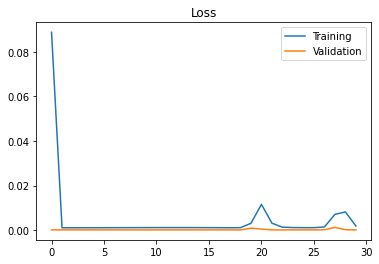

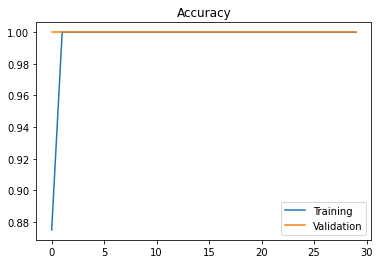

In [180]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losses))), losses, label = 'Training')
plt.plot(list(range(len(losses))), val_losses, label = 'Validation')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(list(range(len(accuracy))), accuracy, label = 'Training')
plt.plot(list(range(len(accuracy))), val_accuracy, label = 'Validation')

plt.title('Accuracy')
plt.legend()
plt.show()

In [181]:
# test accuracy : 

for data in batcher(X_test, y_test, batch_size=y_test.shape[0]) :
    inputs, labels = data
    outputs = model(inputs)

    # test loss
    loss = criterion(outputs, labels)

    # test accuracy
    cat_preds = make_categorical(outputs)
    cat_labels = make_categorical(labels)
    accuracy = accuracy_score(cat_labels, cat_preds)

print('Test loss : ', loss.item())
print('Test accuracy : ', accuracy)

Test loss :  0.00015247499686665833
Test accuracy :  1.0
